In [38]:
import torch
from dataset import PlayingCardDataset
from torch.utils.data import DataLoader
import SpadeClassifier
from mapping import cards
import matplotlib.pyplot as plt

In [39]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1

C:\Users\Sebas\AppData\Local\Temp\ipykernel_1656\4159583811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset: PlayingCardDataset = torch.load("./playing_card_data

10 of Spades


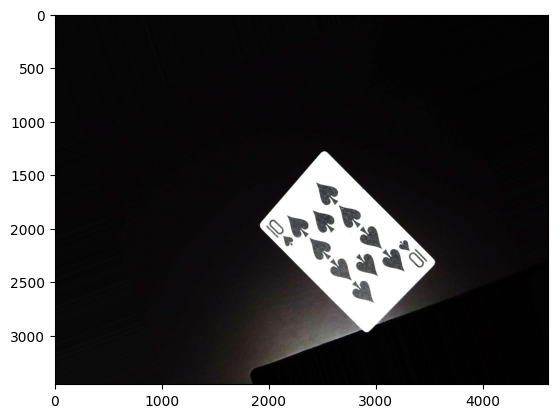

In [40]:
# Load dataset and print sample batch
dataset: PlayingCardDataset = torch.load("./playing_card_dataset.pt")
image, label = next(iter(dataset))
plt.imshow(image.permute(1,2,0))
print(cards[int(label.nonzero()+1)])

In [41]:
# Create Train/Test Split and data loaders
train_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_load, test_load = DataLoader(train_set, batch_size=1, shuffle=True), DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
import importlib
importlib.reload(SpadeClassifier)

<module 'SpadeClassifier' from 'C:\\Users\\Sebas\\PycharmProjects\\Spade\\src\\classifier\\SpadeClassifier.py'>

In [53]:
# Create model
model = SpadeClassifier.SpadeClassifier(53).to(device)

In [54]:
def train_one_epoch() -> None:
    running_loss = 0.0
    
    model.train()
    for iteration, data in enumerate(train_load):
        # Get data and move to the correct device
        images, labels = data
        images = images.to(device) 
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if iteration % 500 == 0:
            print(f"Iteration: {iteration}, Loss: {loss.item()}")
    
    train_loss.append(running_loss / len(train_load))
    
def test_one_epoch() -> None:
    labeled_correctly = 0
    running_loss = 0.0
    
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_load:
            # Move data to the same device as the model
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            if outputs.argmax() == labels.argmax():
                labeled_correctly += 1
    
    running_loss /= len(test_load)
    print("--------------------")
    print(f"Test Loss: {running_loss}\n")
    print(f"Accuracy: {labeled_correctly/len(test_load)*100:.2f}%")
    
    
    test_loss.append(running_loss)


In [55]:
# Define Training loop
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
train_loss = []
test_loss = []
epochs = 5

for epoch in range(epochs):
    train_one_epoch()
    test_one_epoch()

Iteration: 0, Loss: 3.9651131629943848
Iteration: 500, Loss: 3.9965078830718994
Iteration: 1000, Loss: 4.000077724456787
Iteration: 1500, Loss: 3.9801902770996094
Iteration: 2000, Loss: 3.972047805786133
--------------------
Test Loss: 3.367199320542185

Accuracy: 1.09%
--------------------
Test Loss: 0.0

Accuracy: 0.00%
--------------------
Test Loss: 0.0

Accuracy: 0.00%
--------------------
Test Loss: 0.0

Accuracy: 0.00%
--------------------
Test Loss: 0.0

Accuracy: 0.00%


In [ ]:
torch.save(model.state_dict(), "./model.pt")